In [1]:
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp

import sympy
import random

camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)

import camb
from camb import model, initialpower


#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
pars.set_for_lmax(2500);
pars.set_matter_power( kmax=2.0)

#pars.set_accuracy(AccuracyBoost=1)
#data = camb.get_transfer_functions(pars)
#transfer = data.get_cmb_transfer_data()
#
#
#plt.semilogx(transfer.q,transfer.delta_p_l_k[0,7,:],"r") #Null steht fuer ENERGIE Transfer func
reduced_h = 0.675
pars.set_accuracy(AccuracyBoost=2,lSampleBoost=100)
data = camb.get_transfer_functions(pars)
transfer = data.get_cmb_transfer_data()

In [3]:
np.save("transfer_l",transfer.l)


In [2]:
As = 2.2e-9
ns = 0.986
k0 = 0.015


def Bessel(x,l):
    return sp.special.spherical_jn(l,x)

def S(k1,k2,k3):
    
    return 1


In [3]:
def getx(l): #here one can vary the sampling for different l.
    
    if(0<=l<=200):

        return np.linspace(0,1000,10000)
    if(200<l<=300):
        return np.linspace(275,5000,10000)
    
    if(300<l<=400):
        return np.linspace(400,8000,10000)
    else: 
        return np.linspace(600,16000,20000) #propably a different sampling is needed for bigger l... 
    #Must be fixed later!


In [4]:
XMax = 8000.
XSteps = 100000
Stepwidth = XMax/XSteps
x = np.linspace(0,XMax,XSteps)



def Int_G_Num(alpha,beta,l1,x_sample,l2 = False,l3 = False):
    
    l = l1
    
    if(l2 == False):
        l2 = l
    
    if(l3 == False):
        l3 = l
        
    Stepwidth = x_sample[1:]-x_sample[:-1]
    x_sample = x_sample[:-1] #because we are interested in the left-hand 
                             #sum and there is one less step than there are points.
    
        
    a = np.array(1-beta)
    b = np.array((1+alpha+beta)/2.)
    c = np.array((1-alpha + beta)/2.)
    
    BesA = Bessel(np.tensordot(x_sample,a,0),l1)
    BesB = Bessel(np.tensordot(x_sample,b,0),l2)
    BesC = Bessel(np.tensordot(x_sample,c,0),l3)
    
    Stepwidth_x_squared = Stepwidth * x_sample**2

    return Stepwidth_x_squared.dot((BesA*BesB*BesC))
    





In [5]:
beta_initial = np.linspace(0.0,1,30)

AlphaArray = []
alphaacc = 0.015
BetaArray = []
for i in beta_initial:
    
    AlphaArray= np.append(AlphaArray,np.arange(-1+i,1-i,alphaacc))
    for j in range(len(np.arange(-1+i,1-i,alphaacc))):
        BetaArray.append(i)


BetaArray = np.array(BetaArray)



In [6]:
def getqindex(x): #ONLY WORKS FOR ACCURACY BOOST = 2. I didnt see that 
    #other accuracy boosts result in different spacing of transfer.q...
    
    if(x<transfer.q[0]):
        return 0
    
    if(x<=transfer.q[118]):
        
        y = x/transfer.q[0]
        
        return int(round(np.log(y)/np.log(transfer.q[1]/transfer.q[0])))
    
    if(transfer.q[118]<x<=transfer.q[1298]):
        
        b = transfer.q[199]-transfer.q[198]
        return int(round((x-transfer.q[118])/b + 118))
    
    if(transfer.q[1298]<x<=transfer.q[5800]):
        
        b = transfer.q[2001]-transfer.q[2000]
        return int(round((x-transfer.q[1298])/b + 1298))
    
    if(transfer.q[5800]<x<=transfer.q[5805]):
        
        b = transfer.q[5804]-transfer.q[5803]
        return int(round((x-transfer.q[5800])/b + 5800))
    
    if(x>transfer.q[5805]):
        
        print("X IS TOO BIG, WAS NOT FOUND IN TRANSFER.Q")
    

In [7]:
def GetIndexArrays(AlphaArray,BetaArray):
    
    # Fills the arrays with the indices of the transfer.q array. 
    #This takes roughly a minute, but will boost upcoming integrals significantly.

    ak_Indexarray, bk_Indexarray, ck_Indexarray = [],[],[] #will be the arrays of the indices of a*k,b*k,c*k
#with k indices only running up to len(transfer.q)-1

    Onearray = np.array([1]*len(BetaArray)) 
    ak_Indexarray = np.tensordot(transfer.q[:-1],(Onearray-BetaArray),0)
    bk_Indexarray = np.tensordot(transfer.q[:-1],1/2*(Onearray+BetaArray+AlphaArray),0)
    ck_Indexarray = np.tensordot(transfer.q[:-1],1/2*(Onearray+BetaArray-AlphaArray),0)

    Width = len(ak_Indexarray[1])

    for i in range(len(ak_Indexarray)):
        for j in range(Width):
            ak_Indexarray[i,j] = getqindex(ak_Indexarray[i,j])
            bk_Indexarray[i,j] = getqindex(bk_Indexarray[i,j])
            ck_Indexarray[i,j] = getqindex(ck_Indexarray[i,j])
            
            #Warning: The indexarrays are filled with floats, not ints.
            
    ak_Indexarray = ak_Indexarray.astype(int)
    bk_Indexarray = bk_Indexarray.astype(int)
    ck_Indexarray = ck_Indexarray.astype(int)
    
    return ak_Indexarray,bk_Indexarray,ck_Indexarray

ak_Indexarray, bk_Indexarray, ck_Indexarray = GetIndexArrays(AlphaArray,BetaArray)

In [8]:
np.save("ak_Indexarray",ak_Indexarray)
np.save("bk_Indexarray",bk_Indexarray)
np.save("ck_Indexarray",ck_Indexarray)


In [10]:
IntGvalues3 = np.load("IntGvalues3.npy")
l_list3 = np.load("IntGvalues3_l_vals.npy")
IntGvalues = np.load("IntGvalues.npy")
#IntGvalues = np.append(IntGvalues,IntGvalues3,axis =0)
l_list = np.load("l_list.npy")
print(len(IntGvalues),len(l_list))

549 549


In [29]:
#LONG CALCULATION INCOMING. DO NOT ACCIDENTALLY REACTIVATE THIS CELL!!!
#LONG CALCULATION INCOMING. DO NOT ACCIDENTALLY REACTIVATE THIS CELL!!!
#LONG CALCULATION INCOMING. DO NOT ACCIDENTALLY REACTIVATE THIS CELL!!!

Additional_l_list = [825,830,855,885,915]
Additional_l_list2 = [1070,1170,1270,1370]

IntGvalues3 = []
for l in Additional_l_list2:
    print(l)
    IntGvalues3.append(Int_G_Num(AlphaArray,BetaArray,l,getx(l)))

#LONG CALCULATION INCOMING. DO NOT ACCIDENTALLY REACTIVATE THIS CELL!!!
#LONG CALCULATION INCOMING. DO NOT ACCIDENTALLY REACTIVATE THIS CELL!!!
#LONG CALCULATION INCOMING. DO NOT ACCIDENTALLY REACTIVATE THIS CELL!!!

1070
1170
1270
1370


In [16]:
stepwidth =  -transfer.q[:-1]+transfer.q[1:]
k = transfer.q[:-1]
k_inv = k**(-1)

step_k_inv = stepwidth* k_inv

omega = 10
cosarray = np.sin(10*np.log(2*k))


def Int_T(alpha_index,ell_index,omega = 10): #alpha index can be an array now.
    
    if(omega != 10):
        cosarray_intern = np.sin(omega*np.log(2*k))
    else:
        cosarray_intern = cosarray
    
    Transfer_ak = transfer.delta_p_l_k[0,ell_index,(ak_Indexarray.transpose())[alpha_index]]
    Transfer_bk = transfer.delta_p_l_k[0,ell_index,(bk_Indexarray.transpose())[alpha_index]]
    Transfer_ck = transfer.delta_p_l_k[0,ell_index,(ck_Indexarray.transpose())[alpha_index]]
    
    Integral = step_k_inv.dot((Transfer_ak*Transfer_bk*Transfer_ck*cosarray_intern).transpose())
    
    return Integral
    



In [17]:
IntTvalues = []
l_list = np.load("l_list.npy")

cosarray = np.sin(10*np.log(2*k))
for l_index in l_list:
    print(l_index)
    IntTvalues.append(Int_T(np.array(range(len(AlphaArray))),l_index,10))
IntTvalues = np.array(IntTvalues)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [20]:
np.save("IntTvalues.npy",IntTvalues)

In [11]:
def LastIntegral(IntTvalues,IntGvalues,AlphaArray,beta_initial): #calculates the last integral.
    # IntT/IntGvalues must arrays in Alphaarray(not lists.)
    alph_bet_area_element = (AlphaArray[1]-AlphaArray[0])*(beta_initial[1]-beta_initial[0])
    
    Integralsum = IntTvalues.dot(IntGvalues)
    
    Integralsum *= alph_bet_area_element
    
    Integralsum *= (2/np.pi)**3
    
    return Integralsum
    
    
    
    
    
    
    

In [12]:
def blll_const(l1,l2= 0 ,l3 = 0):
    
    if(l2 == 0):
        l2 = l1
        l3 = l1
    
    return 1/27*1/(2*l1+1)*1/(2*l2+1)*1/(2*l3+1)*(1/((l1+l2+l3)+3)+1/(l1+l2+l3))


In [22]:
blllList = []
#IntTvalues = np.load("IntTvalues.npy")
IntGvalues = np.load("IntGvalues.npy")
l_list = np.load("l_list.npy")
print(len(IntTvalues))
for i in range(len(l_list)):
    
    Norm = blll_const(transfer.l[l_list[i]])


    blllList.append(LastIntegral(IntTvalues[i],IntGvalues[i],AlphaArray,beta_initial)/Norm)
    

#plt.figure(figsize=(12,4))
#plt.semilogx(transfer.l[l_index_list][20:],blllList[20:],basex = 10)  
#plt.twinx()
#ax.set_xticks([20,30,40,50,100,200,300,400,500,600,700,800,900,1000])
xs = transfer.l[l_list]
ys = blllList

#print(len(ys_Cos))

549


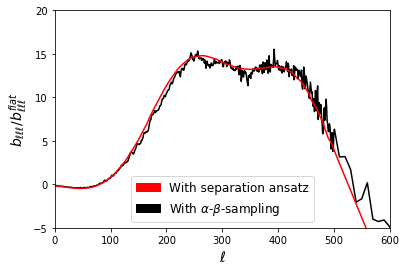

In [42]:
import matplotlib.patches as mpatches

y2 = np.load("IntArrayExpo.npy")
x2 = np.load("Reduced_L_List.npy")
plt.plot(xs,ys,"black")
plt.plot(x2,y2,"red")

plt.xlabel(r"$\ell$",fontsize = 14)
plt.ylabel(r"$b_{\ell\ell\ell}/b_{\ell\ell\ell}^{flat}$",fontsize = 14)
plt.xlim(0,600)
plt.ylim(-5,20)

Rot = mpatches.Patch(color = "red",label = r"With separation ansatz")
Black = mpatches.Patch(color = "black",label = r"With $\alpha$-$\beta$-sampling")

plt.legend(handles =  [Rot, Black],fontsize = 12)
#plt.savefig("Expo.pdf",format = "pdf")
plt.show()

In [ ]:
x = np.linspace(0,10000,10000)
l = 200
a = 0.1
b = 0.95
c = 2-a-b
y = x**2*Bessel(a*x,l)*Bessel(b*x,l)*Bessel(c*x,l)

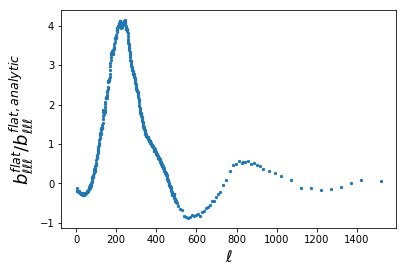

In [11]:
plt.scatter(xs,ys,s = 5)
plt.xlabel(r"$\ell$",fontsize = 16)
plt.ylabel(r"$b_{\ell\ell\ell}^{flat}/b_{\ell\ell\ell}^{flat,analytic}$",fontsize = 18)

plt.show()

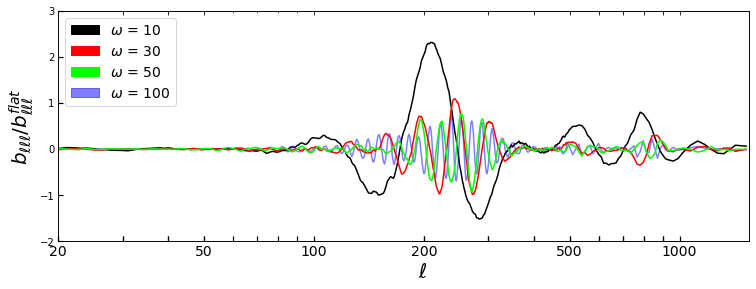

In [34]:
fig = plt.figure(figsize=(12,4))
ax1 = plt.axes([.14,.15,.8,.8])


miny = min(ys)
maxy = max(ys)
botbound = -2
topbound = 3

minx = min(xs)
maxx = max(xs)
leftbound = 20
rightbound = maxx+0.02*(maxx-minx)

ax1.semilogx(xs, ys, "black", label=r"$\omega = 10$")  
ax1.semilogx(xs, blll100,"blue",alpha = 0.5)
ax1.semilogx(xs, blll30,"red")
ax1.semilogx(xs, blll50,"lime")

#ax1.semilogx(xs, ys_Cos,"C1")



#ax1.axvspan(xmin, xmax, ymin=0, ymax=1, alpha=0.2, color="gray")  


#ax1.set_xlabel("Temperatur in K")
#ax1.set_ylabel("R$_{{Cu}}$ in $\\Omega$")
import matplotlib.patches as mpatches
Rot = mpatches.Patch(color = "red",label = r"$\omega$ = 30")
Black = mpatches.Patch(color = "black",label = r"$\omega$ = 10")
Grun = mpatches.Patch(color = "lime",label = r"$\omega$ = 50")
Blue = mpatches.Patch(color = "blue",label = r"$\omega$ = 100",alpha = 0.5)
Ora = mpatches.Patch(color = "C1",label = r"$\omega$ = 10, using cos(k)")

ax1.legend(handles =  [Black,Rot,Grun,Blue],fontsize = 14,loc = "upper left")


ax1.set_xlim(leftbound, rightbound)


new_ax1_xticks = []
new_ax1_xtick_labels = []
for ax1_xtick in [20,30,40,50,100,200,300,400,500,600,700,800,900,1000]:
    new_ax1_xticks.append(ax1_xtick)
    if(ax1_xtick not in [20,50,100,200,500,1000]):
        new_ax1_xtick_labels.append(" ")
        continue
    
    new_ax1_xtick_labels.append(int(ax1_xtick))
    
ax1.set_xticks(np.array(new_ax1_xticks))

ax1.set_xticklabels(new_ax1_xtick_labels,fontsize = 14)
ax1.set_xlim(leftbound, rightbound)
ax1.set_xlabel(r"      $\ell$",fontsize = 20)
ax1.set_ylabel(r"$b_{\ell\ell\ell}/b_{\ell\ell\ell}^{flat}$",fontsize = 20)
ax1.tick_params( axis='both',which = "both", direction ="in",length = 5, width = 1.2)


ax1tw = ax1.twiny() 
ax1tw.semilogx(xs, ys,alpha = 0)  
ax1tw.set_xticks(np.array(new_ax1_xticks))
ax1tw.set_xticklabels(np.array([" "]*len(new_ax1_xticks)))
ax1tw.set_xlim(leftbound, rightbound)
ax1tw.tick_params( axis='both',which = "both", direction ="in")

ax1.set_ylim(botbound, topbound)

#    for L in range(Lower,3*l//2+1):
#        
#        Mult = Q(l,L,k1,l,k2,l)
#        
#        if(Mult != 0):
#            Lsum += Mult*sympy.legendre(L,mu)
###plt.savefig("BispectrumFourOmegas.pdf",format = "pdf")

plt.show()

In [211]:
print(max(ys))

2.3155960236562465


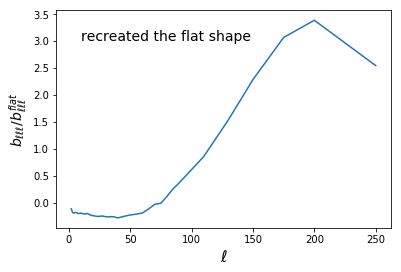

In [28]:
plt.plot(transfer.l[:maxindex],blllList)
plt.xlabel(r"$\ell$", fontsize = 16)
plt.ylabel(r"$b_{\ell\ell\ell}/b_{\ell\ell\ell}^{flat}$",fontsize = 14)
plt.text(10,3.,"recreated the flat shape",fontsize = 14)
#plt.savefig("FlatBispectrum_AlphaBeta.pdf",format = "pdf")
plt.show()


In [103]:
l_index_list = l_list 
print(l_list)
IntTvalues_30 = []
IntTvalues_50 = []
IntTvalues_100 = []

cosarray = np.sin(30*np.log(2*k))
print("30!!!!")
for l in l_index_list:
    print(l)
    IntTvalues_30.append(Int_T(np.array(range(len(AlphaArray))),l))
    
cosarray = np.sin(50*np.log(2*k))
print("50!!!!")
for l in l_index_list:
    print(l)
    IntTvalues_50.append(Int_T(np.array(range(len(AlphaArray))),l))

cosarray = np.sin(100*np.log(2*k))
print("100!!!!")
for l in l_index_list:
    print(l)
    IntTvalues_100.append(Int_T(np.array(range(len(AlphaArray))),l))
    

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
508
518
528
538
548
558
568
578
588
598
608
618
628
638
648
658
668
678
688
698
708
718
733
748
763
778
793
808
823
828
838
853
868
883
898
913
928
958
988
1018
1068
1118
1168
1218
1268
1318
1368
1418
1518


In [13]:
blll30 = []
blll50 = []
blll100 = []
IntTvalues_30 = np.load("IntTvalues_30.npy")
IntTvalues_50 = np.load("IntTvalues_50.npy")
IntTvalues_100 = np.load("IntTvalues_100.npy")
l_list = np.load("l_list.npy")
for i in range(len(l_list)):
    
    blll30.append(LastIntegral(IntTvalues_30[i],IntGvalues[i],AlphaArray,beta_initial)/blll_const(transfer.l[l_list[i]]))
    blll50.append(LastIntegral(IntTvalues_50[i],IntGvalues[i],AlphaArray,beta_initial)/blll_const(transfer.l[l_list[i]]))
    blll100.append(LastIntegral(IntTvalues_100[i],IntGvalues[i],AlphaArray,beta_initial)/blll_const(transfer.l[l_list[i]]))



import matplotlib.patches as mpatches

Rot = mpatches.Patch(color = "red",label = r"$\omega$ = 30")
Black = mpatches.Patch(color = "black",label = r"$\omega$ = 10, using sinus")
Grun = mpatches.Patch(color = "green",label = r"$\omega$ = 100")
Blue = mpatches.Patch(color = "blue",label = r"$\omega$ = 50")



plt.plot(transfer.l[l_list],blllList,"black",marker = ".",linewidth = 0.6)
plt.plot(transfer.l[l_list],blll30,"r",marker = ".",linewidth = 0.6)
plt.plot(transfer.l[l_list],blll50,"b",marker = ".",linewidth = 0.6)
plt.plot(transfer.l[l_list],blll100,"g",marker = ".",linewidth = 0.6)
plt.legend(handles =  [Black],fontsize = 12)
plt.xlabel(r"$\ell$", fontsize = 16)
plt.ylabel(r"$b_{\ell\ell\ell}/b_{\ell\ell\ell}^{flat}$",fontsize = 14)

#plt.savefig("NonFlatBispectrum_Very_Dense_l_sampling.pdf",format = "pdf")
plt.show()


NameError: name 'IntGvalues' is not defined

In [107]:
np.save("IntTvalues_30",IntTvalues_30)
np.save("IntTvalues_50",IntTvalues_50)
np.save("IntTvalues_100",IntTvalues_100)

In [108]:
np.save("IntTvalues_Cos",IntTvaluesCos)
np.save("IntTvalues_Flat",IntTvaluesFlat)
np.save("IntGvalues",IntGvalues)

In [109]:
np.save("l_list",l_list)